In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_hnhm3gyt.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


## Model definition

In the previous example we assume constant thickness to be able to reduce the problem to one dimension. This keeps the probabilistic model fairly simple since we do not need to deel with complex geometric structures. Unfortunaly, geology is all about dealing with complex three dimensional structures. In the moment data spread across the physical space, the probabilistic model will have to expand to relate data from different locations. In other words, the model will need to include either interpolations, regressions or some other sort of spatial functions. In this paper, we use an advance universal co-kriging interpolator. Further implications of using this method will be discuss below but for this lets treat is a simple spatial interpolation in order to keep the focus on the constraction of the probabilistic model.

In [2]:
geo_model = gp.create_model('2-layers')
gp.init_data(geo_model, extent=[0, 12e3, -2e3, 2e3, 0, 4e3], resolution=[500,5,500])

Active grids: ['regular']


2-layers  2020-02-17 10:34

In [3]:
geo_model.add_surfaces('surface 1')
geo_model.add_surfaces('surface 2')
geo_model.add_surfaces('basement')
dz = geo_model.grid.regular_grid.dz
geo_model.surfaces.add_surfaces_values([dz, 0, 0], ['dz'])
geo_model.surfaces.add_surfaces_values(np.array([2.6, 2.4, 3.2]), ['density'])

,surface,series,order_surfaces,isActive,color,id,dz,density
0,surface 1,Default series,1,nan,#015482,1,8,2.6
1,surface 2,Default series,2,nan,#9f0052,2,0,2.4
2,basement,Default series,3,nan,#ffbe00,3,0,3.2


In [4]:
geo_model.add_surface_points(3e3, 0, 3.05e3, 'surface 1')
geo_model.add_surface_points(9e3, 0, 3.05e3, 'surface 1')

geo_model.add_surface_points(3e3, 0, 1.02e3, 'surface 2')
geo_model.add_surface_points(9e3, 0, 1.02e3, 'surface 2')

geo_model.add_orientations(  6e3, 0, 4e3, 'surface 1', [0,0,1])

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,6000.0,0.0,4000.0,0.5001,0.5001,0.624267,0.0,0.0,1.0,0.0,0.0,1.0,surface 1,Default series,1,1,0.01


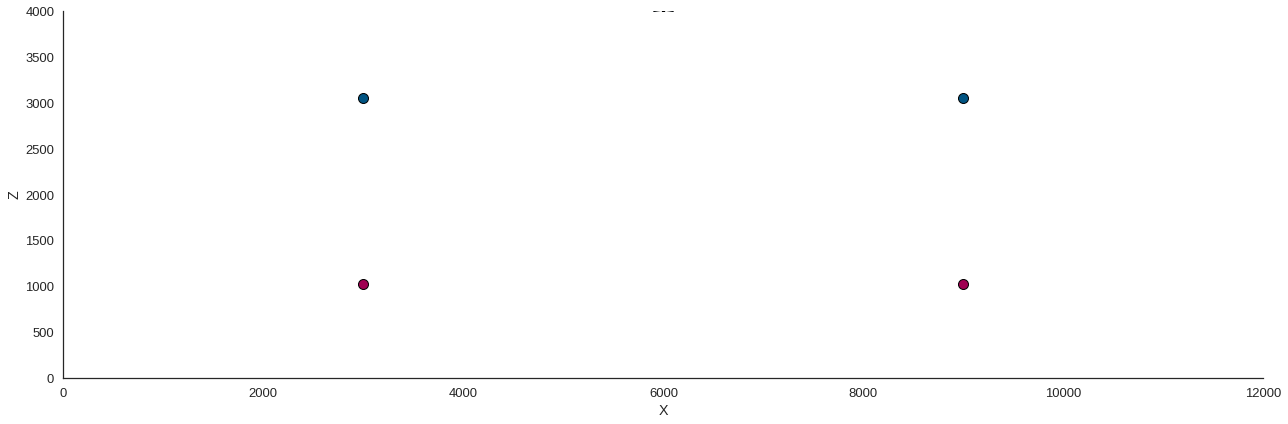

In [5]:
gp.plot.plot_data(geo_model)

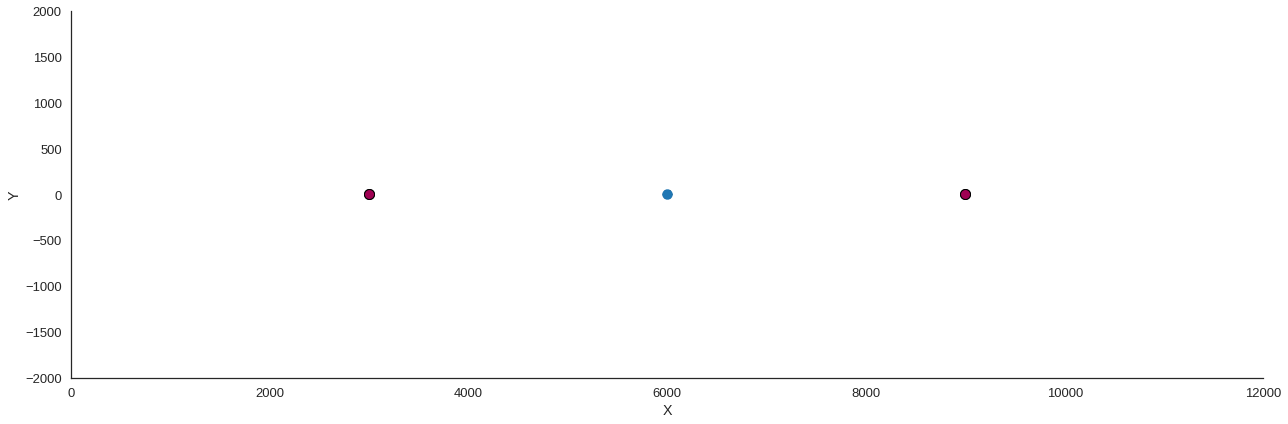

In [6]:
device_loc = np.array([[6e3, 0, 4e3]])
import matplotlib.pyplot as plt
gp.plot.plot_data(geo_model, direction='z')
plt.scatter(device_loc[:,0], device_loc[:, 1], s=100)

In [7]:
device_loc

array([[6000.,    0., 4000.]])

In [8]:
geo_model.set_centered_grid(device_loc,  resolution = [10, 10, 60], radio=4000)

Active grids: ['regular' 'centered']


Grid Object. Values: 
array([[ 1.20000000e+01, -1.60000000e+03,  4.00000000e+00],
       [ 1.20000000e+01, -1.60000000e+03,  1.20000000e+01],
       [ 1.20000000e+01, -1.60000000e+03,  2.00000000e+01],
       ...,
       [ 1.00000000e+04,  4.00000000e+03, -3.46242817e+02],
       [ 1.00000000e+04,  4.00000000e+03, -6.79590693e+02],
       [ 1.00000000e+04,  4.00000000e+03, -1.04000000e+03]])

In [9]:
geo_model.grid.centered_grid.values.max(axis=0)

array([10000.,  4000.,  3760.])

In [10]:
geo_model.additional_data

values
Structure isLith                                        True
          isFault                                      False
          number faults                                    0
          number surfaces                                  2
          number series                                    1
          number surfaces per series                     [2]
          len surfaces surface_points                 [2, 2]
          len series surface_points                      [4]
          len series orientations                        [1]
Options   dtype                                      float32
          output                                     geology
          theano_optimizer                      fast_compile
          device                                        cuda
          verbosity                                     None
Kriging   range                                            0
          $C_o$                                            0
          drift equations                                [0]
          nugget grad                                   0.01
          nugget scalar                                1e-06
Rescaling rescaling factor                             12000
          centers                      [6000.0, 0.0, 2510.0]

In [11]:
geo_model.interpolator.dtype

'float32'

In [12]:
gp.set_interpolator(geo_model, output=['gravity'], pos_density=2,  gradient=True,
                    theano_optimizer='fast_run')            

Compiling theano function...
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  0
Compilation Done!


In [13]:
geo_model.interpolator.theano_graph.compute_type 

['gravity', 'geology']

In [14]:
geo_model.grid.active_grids

array([ True, False, False, False,  True])

In [15]:
gp.compute_model(geo_model, set_solutions=True)


Lithology ids 
  [3.001483   3.0014548  3.0014265  ... 0.99888045 0.9988394  0.99880016] 

In [16]:
geo_model.solutions.fw_gravity

array([-345.69092], dtype=float32)

In [17]:
geo_model.interpolator.theano_graph.tz.get_value()

array([-0.00348708, -0.00217323, -0.00035783, ..., -0.19573145,
       -0.20810947, -0.21112786], dtype=float32)

In [69]:
geo_model.interpolator.theano_graph.tz.get_value()

array([-3.4870757e-06, -2.1732260e-06, -3.5782816e-07, ...,
       -1.9573145e-04, -2.0810947e-04, -2.1112787e-04], dtype=float32)

In [18]:
# Reset
grav__= [] 

In [19]:
def plot(z1, z2):
    geo_model.modify_surface_points([2,3], Z=z1)
    geo_model.modify_surface_points([0,1], Z=z2)
    gp.compute_model(geo_model, output='gravity')
    grav__.append(geo_model.solutions.fw_gravity)
    #geo_model.set_active_grid(['regular'])
    #gp.compute_model(geo_model)
    gp.plot.plot_section(geo_model, 0, show_data=True, direction='y')
    plt.scatter(geo_model.grid.centered_grid.values[:, 0], geo_model.grid.centered_grid.values[:, 2],
               c='k', s= 3)
    plt.show()
    plt.plot(grav__, 'o')
    plt.ylabel('grav')
    plt.show()


### Genereate your own observations!

In [20]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(plot, z1=(2.7e3, 3.5e3, 100), z2=(.8e3, 1.6e3, .1e3))

interactive(children=(FloatSlider(value=3100.0, description='z1', max=3500.0, min=2700.0, step=100.0), FloatSl…

<function __main__.plot(z1, z2)>

In [48]:
np.asarray(grav__).ravel()

array([-0.3548658 , -0.35558686, -0.3563156 , -0.35558686, -0.3548658 ,
       -0.3534237 , -0.35201198, -0.3534237 , -0.3548658 , -0.3563401 ,
       -0.3548658 , -0.35558686, -0.3548658 , -0.3541554 , -0.3534569 ,
       -0.3527707 , -0.35424498, -0.35575098, -0.3572901 , -0.35575098,
       -0.35424498, -0.35575098, -0.35424498, -0.35575098, -0.35424498,
       -0.35575098, -0.35643718, -0.35713565, -0.35643718], dtype=float32)

_____
### Bayesian

In [49]:
from gempy.bayesian.plot_posterior import default_blue

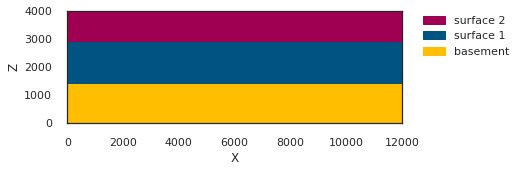

In [50]:
 gp.plot.plot_section(geo_model, 0, show_data=True, direction='y', show_topo=True)

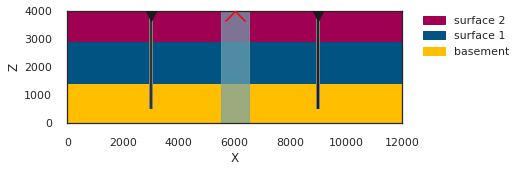

In [51]:
p = gp.plot.plot_section(geo_model, 0, show_data=True, direction='y')
p.fig.axes[-1].scatter([3e3], [3.9e3],  marker='v', s =200, c='k',zorder=10)
p.fig.axes[-1].scatter([9e3], [3.9e3],  marker='v', s =200, c='k', zorder=10)
p.fig.axes[-1].scatter([6e3], [4e3],  marker='x', s =400, c='red',zorder=10)

p.fig.axes[-1].vlines(3e3, .5e3, 10e3, linewidth=4, color='gray', )
p.fig.axes[-1].vlines(9e3, .5e3, 10e3, linewidth=4, color='gray')
p.fig.axes[-1].vlines(3e3, .5e3, 10e3)
p.fig.axes[-1].vlines(9e3, .5e3, 10e3)
p.fig.axes[-1].vlines(9e3, .5e3, 10e3)
p.fig.axes[-1].fill_between(x=[5.5e3,6.5e3], y1=[0,0], y2=[10e3,10e3], alpha=.7, color=default_blue)

### Setting gempy into a pymc function


In [18]:
geo_model.interpolator.theano_graph.sig_slope.set_value(150)

In [19]:
geo_model.interpolator.theano_graph.input_parameters_loop[4]

All the surface_points points at once

In [20]:
geo_model.interpolator.theano_graph.compute_type

['gravity', 'geology']

In [21]:
# # Test gradient

import theano
import theano.tensor as tt
theano.config.compute_test_value = 'ignore'
geo_model_T = theano.OpFromGraph(geo_model.interpolator.theano_graph.input_parameters_loop,
                                [theano.grad(geo_model.interpolator.theano_graph.theano_output()[12][0],
                                             geo_model.interpolator.theano_graph.input_parameters_loop[4])],
                                 inline=True,
                                 on_unused_input='ignore',
                                 name='forw_grav')

In [22]:
i = geo_model.interpolator.get_python_input_block()
th_f = theano.function([], geo_model_T(*i), on_unused_input='warn')

In [39]:
geo_model.interpolator.theano_graph.sig_slope.set_value(20)

In [40]:
th_f()

array([[   0.      ,    0.      ,   38.187046],
       [   0.      ,    0.      ,   38.18597 ],
       [   0.      ,    0.      , -112.59959 ],
       [   0.      ,    0.      , -112.59899 ]], dtype=float32)

## Setup Bayesian model

In [41]:
geo_model.set_active_grid('centered', reset=True)

Active grids: ['centered']


Grid Object. Values: 
array([[ 2000.        , -4000.        ,  3760.        ],
       [ 2000.        , -4000.        ,  3712.        ],
       [ 2000.        , -4000.        ,  3708.10332395],
       ...,
       [10000.        ,  4000.        ,  -346.24281707],
       [10000.        ,  4000.        ,  -679.59069306],
       [10000.        ,  4000.        , -1040.        ]])

In [42]:
i = geo_model.interpolator.get_python_input_block()
theano.config.compute_test_value = 'ignore'
geo_model_T = theano.OpFromGraph(geo_model.interpolator.theano_graph.input_parameters_loop,
                                [geo_model.interpolator.theano_graph.theano_output()[12]],
                                 inline=False,
                                 on_unused_input='ignore',
                                 name='forw_grav')
#th_f = theano.function([], geo_model_T(*i), on_unused_input='warn')


In [44]:
# We convert a python variable to theano.shared
input_sh = []
i = geo_model.interpolator.get_python_input_block()
for ii in i:
    input_sh.append(theano.shared(ii))

# We get the rescaling parameters:
rf = geo_model.rescaling.df.loc['values', 'rescaling factor'].astype('float32')
centers = geo_model.rescaling.df.loc['values', 'centers'].astype('float32')

# We create pandas groups by id to be able to modify several points at the same time:
g = geo_model.surface_points.df.groupby('id')
l = theano.shared(np.array([], dtype='float64'))

In [47]:
g_obs_p = 1e3 * np.array([-0.3548658 , -0.35558686, -0.3563156 , -0.35558686, -0.3548658 ,
       -0.3534237 , -0.35201198, -0.3534237 , -0.3548658 , -0.3563401 ,
       -0.3548658 , -0.35558686, -0.3548658 , -0.3541554 , -0.3534569 ,
       -0.3527707 , -0.35424498, -0.35575098, -0.3572901 , -0.35575098,
       -0.35424498, -0.35575098, -0.35424498, -0.35575098, -0.35424498,
       -0.35575098, -0.35643718, -0.35713565, -0.35643718], dtype='float32')

In [48]:
## theano.config.compute_test_value = 'ignore'

with pm.Model() as model:

#     depths = pm.Normal('depths', geo_model.surface_points.df[['X', 'Y', 'Z']],
#                    d, shape=(4, 3), dtype='float32')
    
    depths = pm.Normal('depths', geo_model.surface_points.df['Z'],
                   np.array([200, 200, 200, 200]), shape=(4), dtype='float32')

    depths_r = (depths - centers[2])/rf + 0.5001
    
    input_sh[4] = tt.set_subtensor(input_sh[4][:, 2], depths_r)
    # input_sh[4] = depths_r
    grav = geo_model_T(*input_sh)
    
    grav = pm.Deterministic('gravity', grav[0])
    
  #   sigma = pm.Gamma('$\sigma$', 1, .7)
  #  sigma = pm.Deterministic('$\sigma$', theano.shared(np.array(250)))
    sigma = pm.Normal('sigma', 250, 40)
    obs_grav = pm.Normal('y', mu=grav, sd=sigma, observed=g_obs_p)



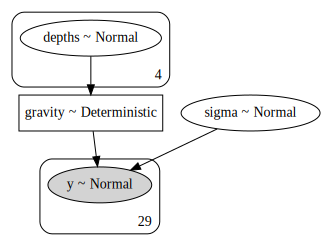

In [49]:
pm.model_to_graphviz(model)

### Bayesian inference

In [35]:
with model:
    trace = pm.sample(400, chains=1, tune=300,
                      #init='adapt_diag',
                      # trace= pm.backends.SQLite('Gravity1'),
                      discard_tuned_samples=False,
                      compute_convergence_checks=False,
                      )
   

Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gpuarray.opt.GraphToGPU object at 0x7fb8f2bc1780>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/theano/gof/opt.py", line 251, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/theano/gof/opt.py", line 97, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/theano/gpuarray/opt.py", line 429, in apply
    outputs = new_ops(*[mapping[i] for i in node.inputs], return_list=True)
  File "/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/theano/gof/op.py", line 615, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/home/miguel/.conda/envs/m_gempy/lib/python3

In [36]:
break

SyntaxError: 'break' outside loop (<ipython-input-36-6aaf1f276005>, line 4)

### Predictive prior and posterior:

In [37]:
with model:
    prior = pm.sample_prior_predictive(1000)
    post = pm.sample_posterior_predictive(trace)

100%|██████████| 700/700 [00:03<00:00, 182.82it/s]


#### Sampler stats:

In [38]:
trace.get_sampler_stats('depth')

array([8, 3, 4, 2, 8, 7, 5, 8, 8, 8, 6, 3, 8, 4, 5, 4, 7, 7, 4, 3, 5, 3,
       4, 2, 6, 5, 5, 4, 2, 7, 4, 3, 5, 5, 2, 6, 6, 6, 3, 5, 2, 6, 6, 5,
       5, 5, 5, 5, 3, 2, 6, 7, 6, 5, 3, 6, 5, 4, 4, 5, 4, 4, 5, 4, 4, 6,
       5, 4, 4, 4, 5, 4, 6, 5, 4, 5, 4, 2, 6, 5, 4, 4, 4, 5, 5, 6, 5, 5,
       4, 4, 6, 3, 4, 3, 6, 6, 6, 5, 5, 4, 6, 5, 5, 5, 3, 3, 3, 5, 5, 6,
       6, 6, 4, 4, 3, 4, 4, 4, 4, 5, 5, 6, 5, 4, 3, 5, 5, 4, 4, 4, 4, 5,
       3, 4, 4, 5, 4, 4, 3, 4, 4, 5, 6, 5, 5, 4, 5, 5, 5, 5, 5, 5, 3, 4,
       5, 5, 5, 5, 4, 4, 5, 5, 4, 3, 5, 3, 4, 4, 5, 4, 1, 5, 6, 5, 4, 4,
       4, 4, 2, 4, 4, 4, 5, 4, 4, 4, 4, 4, 3, 6, 5, 5, 5, 6, 4, 4, 6, 5,
       6, 5, 4, 4, 4, 3, 5, 4, 4, 3, 4, 4, 3, 5, 4, 5, 4, 4, 4, 4, 3, 3,
       4, 3, 2, 1, 5, 5, 5, 4, 3, 3, 4, 4, 5, 4, 5, 6, 5, 5, 4, 5, 4, 3,
       4, 4, 4, 3, 4, 4, 5, 5, 5, 5, 4, 2, 5, 4, 4, 4, 4, 3, 3, 4, 4, 4,
       2, 4, 4, 4, 5, 2, 4, 4, 3, 5, 4, 3, 3, 5, 4, 4, 4, 4, 3, 5, 4, 3,
       5, 4, 4, 5, 3, 4, 5, 4, 4, 5, 5, 5, 4, 3, 4,

In [39]:
trace.get_sampler_stats('step_size')

array([2.4050426 , 0.90216112, 1.38477242, 0.14457879, 0.22535781,
       0.37308884, 0.05044327, 0.09142682, 0.16285772, 0.29083693,
       0.27642147, 0.05559142, 0.10539119, 0.19909227, 0.31364388,
       0.05169458, 0.09584508, 0.17742414, 0.30252225, 0.11060009,
       0.19864512, 0.18866872, 0.32030818, 0.03239517, 0.05923405,
       0.1063932 , 0.18464239, 0.30564366, 0.06382848, 0.11318072,
       0.17791613, 0.11080898, 0.19132453, 0.29300493, 0.0368061 ,
       0.063892  , 0.10880701, 0.13555098, 0.20234699, 0.26593636,
       0.04047004, 0.06837515, 0.11328523, 0.18849398, 0.28027734,
       0.06035348, 0.09859215, 0.15931563, 0.25428041, 0.04027391,
       0.06343193, 0.10312467, 0.15852093, 0.24947868, 0.09729934,
       0.15586708, 0.2057268 , 0.30789572, 0.11073425, 0.12447771,
       0.19622606, 0.1826778 , 0.2158775 , 0.31797648, 0.0913313 ,
       0.14192538, 0.20698877, 0.16724245, 0.14430174, 0.18417189,
       0.26904442, 0.07746922, 0.11684965, 0.17741654, 0.16781

In [40]:
trace.get_values('gravity')


array([-15030.303 , -15019.281 , -14675.032 , -14675.032 , -14662.291 ,
       -14659.566 , -14655.348 , -14659.041 , -14653.154 , -14648.529 ,
       -14671.887 , -14671.887 , -14641.559 , -14645.836 , -14620.26  ,
       -14705.092 , -14606.288 , -14620.887 , -14638.371 , -14659.789 ,
       -14686.67  , -14607.289 , -14728.148 , -14728.148 , -14639.488 ,
       -14620.664 , -14653.775 , -14674.719 , -14638.798 , -14668.669 ,
       -14670.015 , -14697.672 , -14634.455 , -14646.086 , -14646.086 ,
       -14654.373 , -14674.012 , -14603.1875, -14653.353 , -14660.146 ,
       -14660.146 , -14661.711 , -14627.543 , -14646.477 , -14628.748 ,
       -14652.822 , -14681.172 , -14672.612 , -14667.291 , -14667.291 ,
       -14611.069 , -14603.008 , -14673.369 , -14638.585 , -14641.395 ,
       -14649.979 , -14686.156 , -14654.043 , -14693.08  , -14662.035 ,
       -14636.48  , -14628.304 , -14671.397 , -14659.554 , -14621.604 ,
       -14653.22  , -14639.118 , -14610.1   , -14646.087 , -1460

In [41]:
trace.get_values('depths')



array([[7381.257 , 7417.3345, 4399.5493, 4335.8306],
       [7350.37  , 7418.3066, 4400.7314, 4255.443 ],
       [7361.4604, 7318.442 , 4395.332 , 2198.1426],
       ...,
       [8533.692 , 7661.925 , 4544.8438, 2010.5876],
       [8712.452 , 8379.462 , 4799.7227, 2242.1514],
       [8720.9795, 7450.2705, 3412.8066, 2462.5696]], dtype=float32)

### Plots:

In [42]:
import arviz as az

In [43]:

data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=post)
data.posterior

<xarray.Dataset>
Dimensions:       (chain: 1, depths_dim_0: 4, draw: 700)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 693 694 695 696 697 698 699
  * depths_dim_0  (depths_dim_0) int64 0 1 2 3
Data variables:
    depths        (chain, draw, depths_dim_0) float32 7381.257 ... 2462.5696
    sigma         (chain, draw) float32 327.2418 347.89722 ... 198.42216
    gravity       (chain, draw) float32 -15030.303 -15019.281 ... -14638.219
Attributes:
    created_at:                 2020-02-11T10:13:24.526838
    inference_library:          pymc3
    inference_library_version:  3.7

#### Save data

In [44]:
#data.to_netcdf('gravity_thick_layer_p')

'gravity_thick_layer_p'

#### Load data

In [51]:
# data = az.from_netcdf('gravity_easy')
# data = az.from_netcdf('gravity_thin_layer_2')
data = az.from_netcdf('gravity_thick_layer_p')

In [52]:
data.prior['depth_0'] = data.prior['depths'][0 ,:, 0]
data.prior['depth_1'] = data.prior['depths'][0 ,:, 1]
data.prior['depth_2'] = data.prior['depths'][0 ,:, 2]
data.prior['depth_3'] = data.prior['depths'][0 ,:, 3]

In [53]:
data.posterior['depth_0'] =  data.posterior['depths'][0 ,:, 0]
data.posterior['depth_1'] =  data.posterior['depths'][0 ,:, 1]
data.posterior['depth_2'] =  data.posterior['depths'][0 ,:, 2]
data.posterior['depth_3'] =  data.posterior['depths'][0 ,:, 3]

In [54]:
data.posterior['like_std2'] = np.array([5]*200)

In [55]:
data.posterior

<xarray.Dataset>
Dimensions:       (chain: 1, depths_dim_0: 4, draw: 700, like_std2: 200)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 693 694 695 696 697 698 699
  * depths_dim_0  (depths_dim_0) int64 0 1 2 3
  * like_std2     (like_std2) int64 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5 5
Data variables:
    depths        (chain, draw, depths_dim_0) float32 ...
    sigma         (chain, draw) float32 ...
    gravity       (chain, draw) float32 ...
    depth_0       (draw) float32 ...
    depth_1       (draw) float32 ...
    depth_2       (draw) float32 ...
    depth_3       (draw) float32 ...
Attributes:
    created_at:                 2020-02-11T10:13:24.526838
    inference_library:          pymc3
    inference_library_version:  3.7

<IPython.core.display.Javascript object>


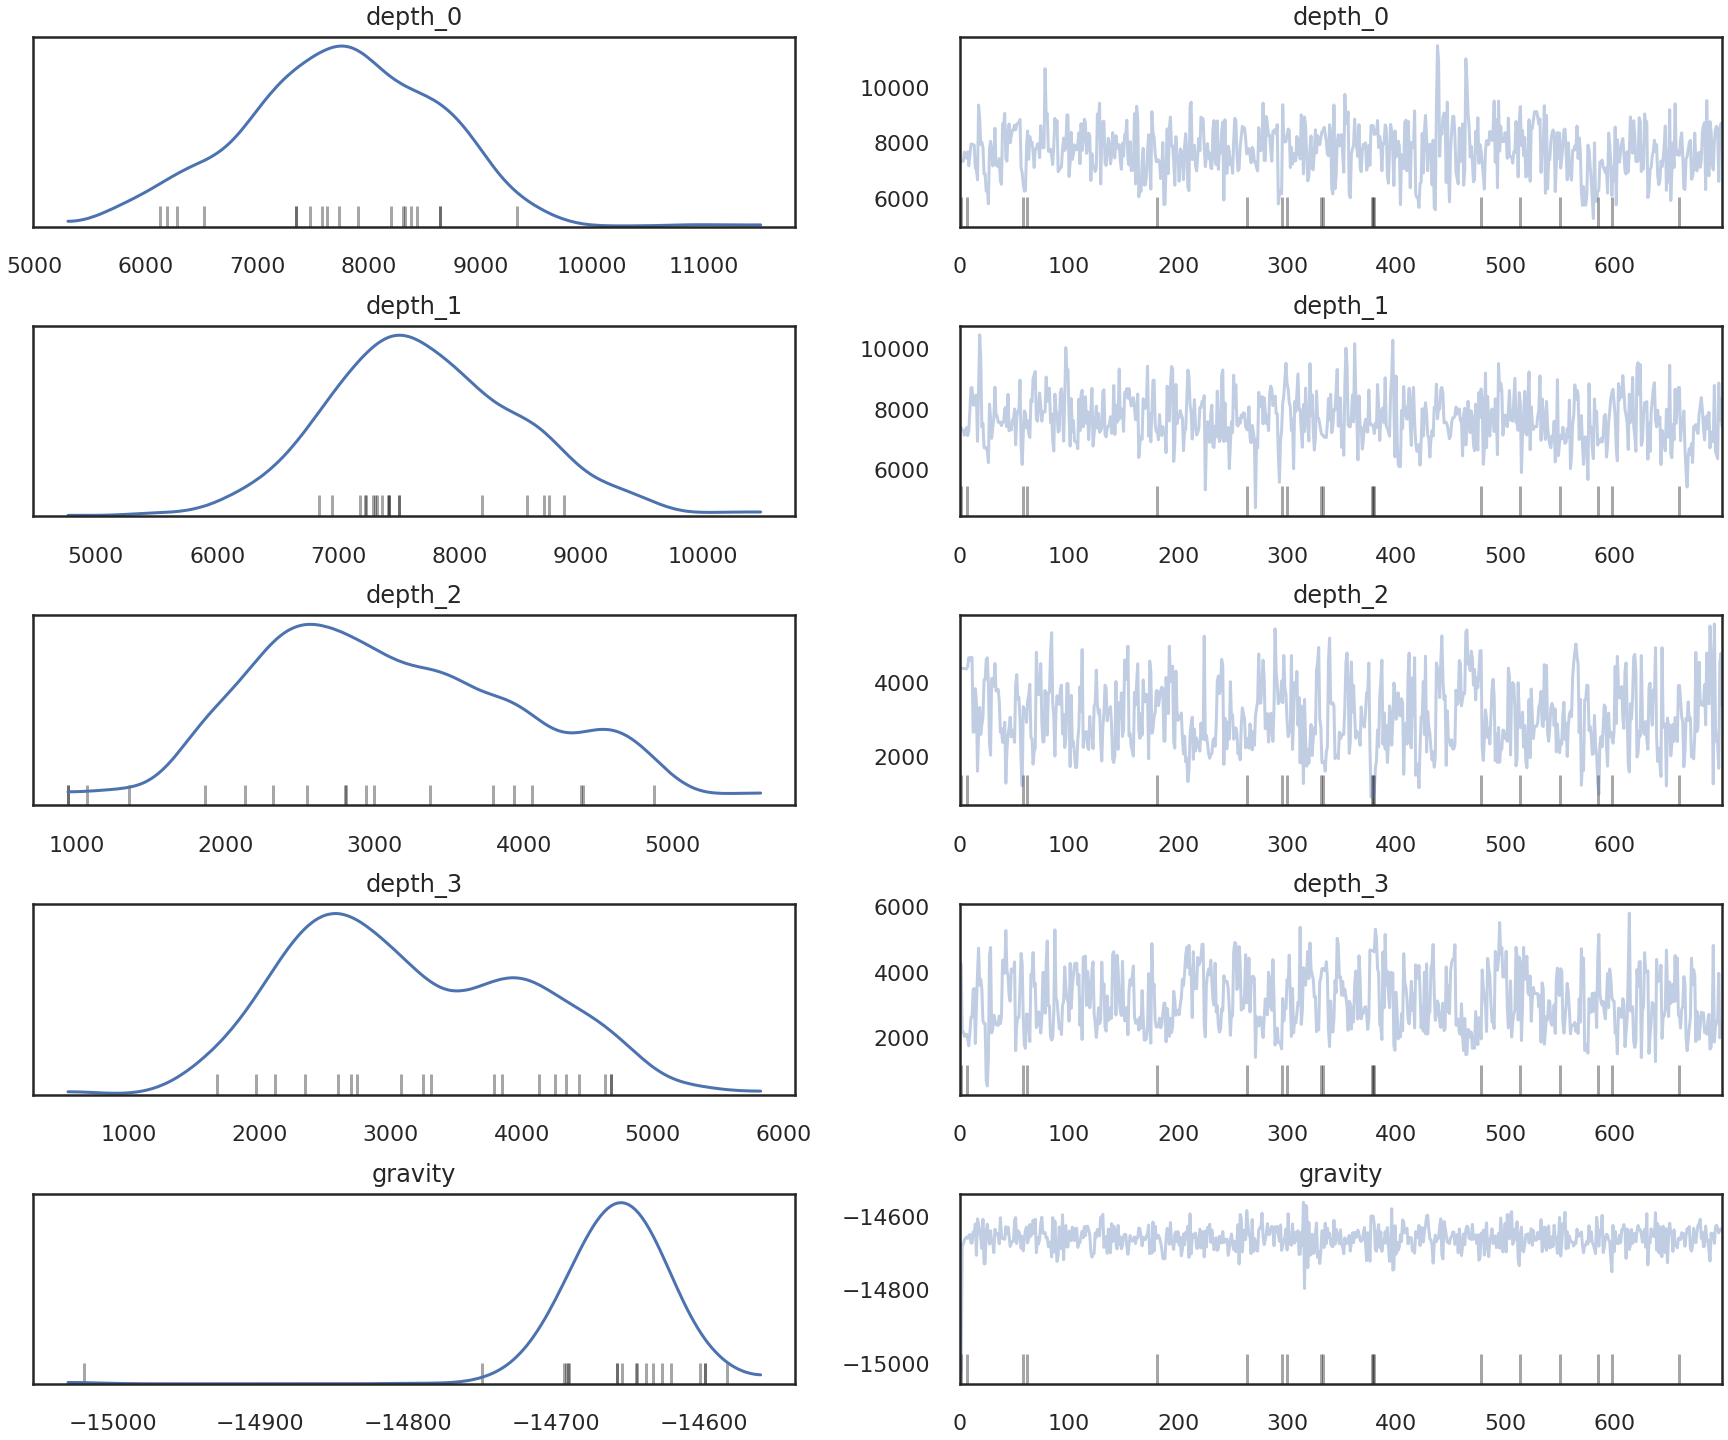

In [56]:
az.plot_trace(data, var_names=['depth_0', 'depth_1', 'depth_2', 'depth_3', 'gravity']);


<IPython.core.display.Javascript object>


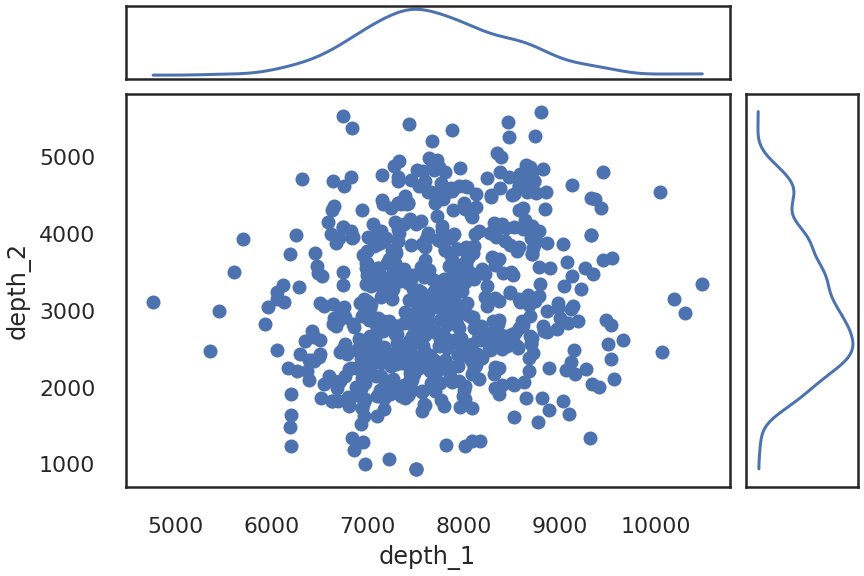

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa6f886fa90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa6f87d3710>)

In [57]:
az.plot_joint(data, var_names=['depth_1', 'depth_2'])

In [58]:
# !git pull
from gempy.bayesian import plot_posterior as pp

import seaborn as sns


In [63]:
def change_iteration(iteration):
    p.plot_posterior(['depth_2', 'depth_3'], ['gravity', 'sigma'], 'y', iteration)
    #p.axjoin.set_xlim(2000, 14000)
    #p.axjoin.set_ylim(2000, 14000)
  #  geo_model.modify_surface_points([0,1,2,3], Z=data.posterior['depths'][0, iteration])#data.get_values('depths')[iteration])
  #  gp.compute_model(geo_model, output='gravity')
  #  gp.plot.plot_section(geo_model, 0)
    
    # p.plot_posterior(['$\mu$', '$\sigma$'], ['$\mu$', '$\sigma$'], 'y', iteration)

<IPython.core.display.Javascript object>


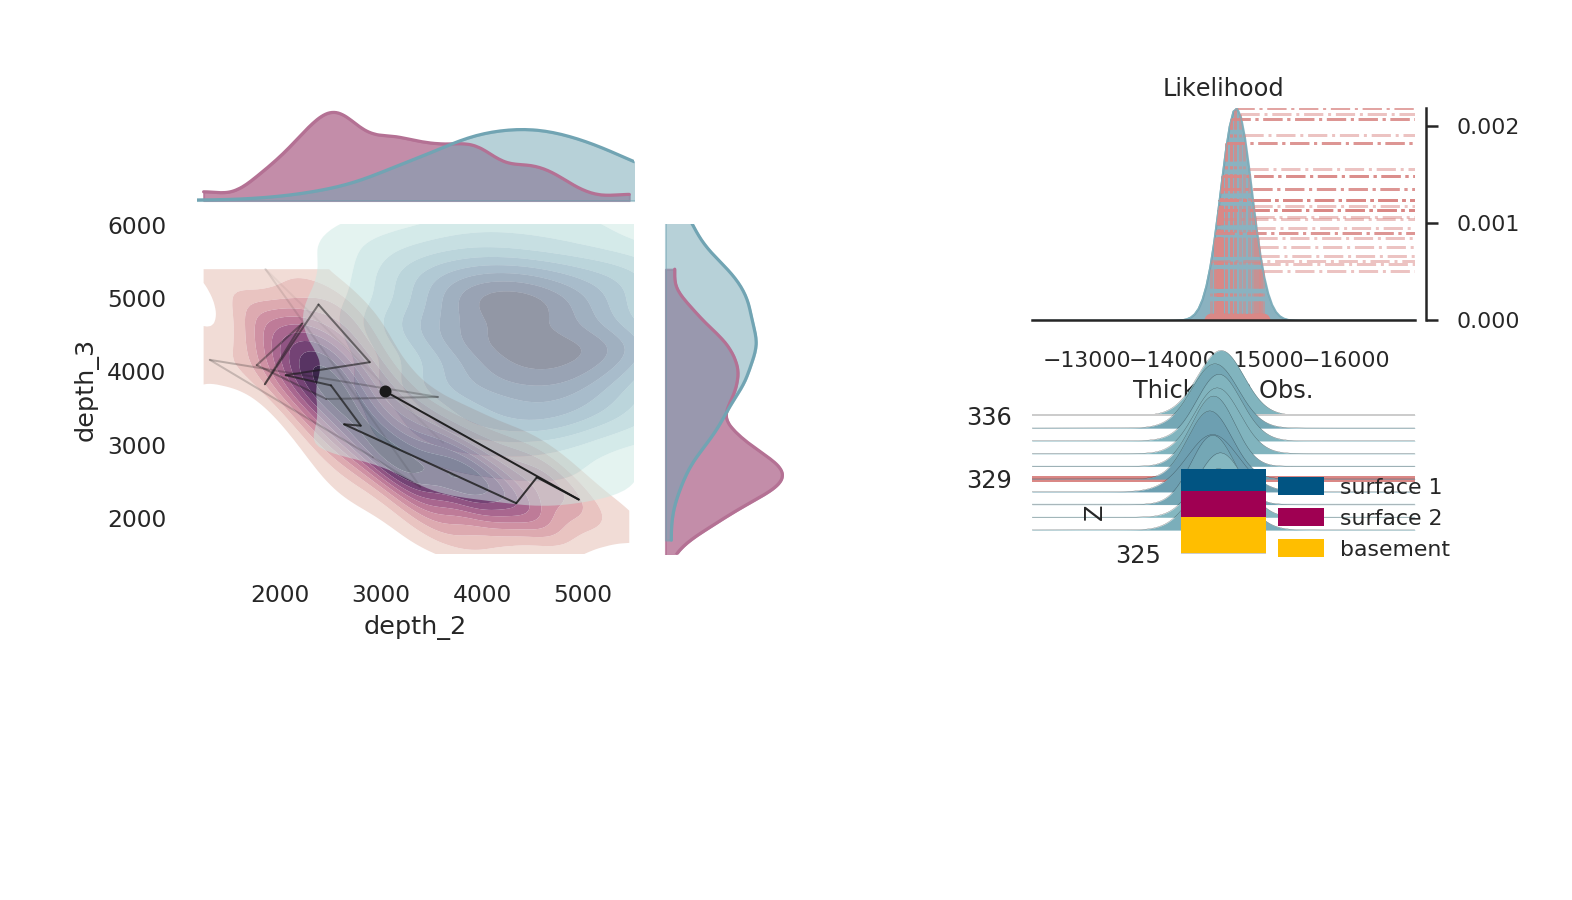

In [64]:
%matplotlib notebook
from importlib import reload
reload(pp)
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,3), joyplot=True)

In [65]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(change_iteration, iteration=(0, 700, 30))

interactive(children=(IntSlider(value=330, description='iteration', max=700, step=30), Output()), _dom_classes…

<function __main__.change_iteration(iteration)>

In [62]:
#p.axjoin.set_xlim(2000, 14000)
#p.axjoin.set_ylim(2000, 14000)

(2000, 14000)

### Plot models:

In [66]:
geo_model.set_active_grid('regular')

Active grids: ['regular' 'centered']


Grid Object. Values: 
array([[ 1.00000000e+01,  5.00000000e+03,  1.00000000e+01],
       [ 1.00000000e+01,  5.00000000e+03,  3.00000000e+01],
       [ 1.00000000e+01,  5.00000000e+03,  5.00000000e+01],
       ...,
       [ 2.10000000e+04,  2.10000000e+04, -8.45432492e+03],
       [ 2.10000000e+04,  2.10000000e+04, -9.28733037e+03],
       [ 2.10000000e+04,  2.10000000e+04, -1.01600000e+04]])

Active grids: ['regular' 'centered']


<IPython.core.display.Javascript object>


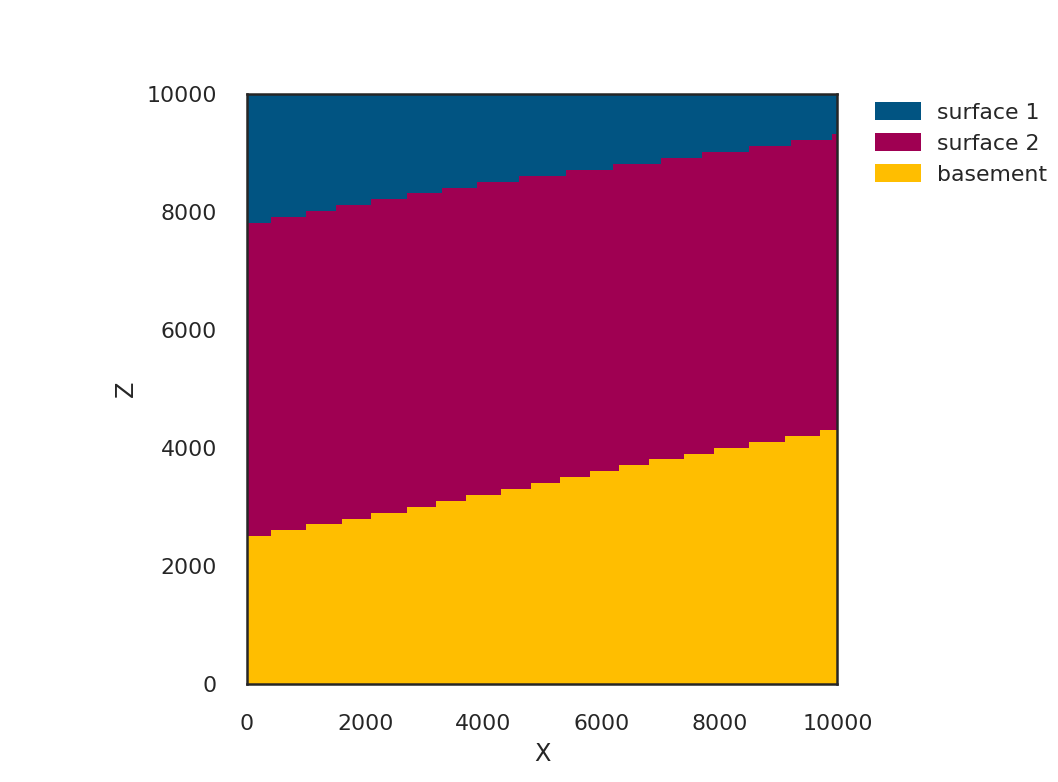

In [71]:

geo_model.set_regular_grid(extent=[0, 10000, 0, 10000, 0, 10000], resolution=[100,2,100])
iteration=300

geo_model.modify_surface_points([0,1,2,3], Z=data.posterior['depths'][0, iteration])#data.get_values('depths')[iteration])
gp.compute_model(geo_model, output='gravity')
gp.plot.plot_section(geo_model, 0)

In [68]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,color,vertices,edges,id,dz,density
0,surface 1,Default series,1,False,False,True,#015482,"[[0.0, 0.0, 7351.535], [0.0, 5000.0, 7351.535]...","[[2, 1, 0], [3, 1, 2], [4, 3, 2], [5, 3, 4], [...",1,20.0,2.6
1,surface 2,Default series,2,False,False,True,#9f0052,"[[0.0, 0.0, 4369.0776], [0.0, 5000.0, 4369.077...","[[2, 1, 0], [3, 1, 2], [4, 3, 2], [5, 3, 4], [...",2,0.0,2.4
2,basement,Default series,3,True,False,True,#ffbe00,NaN,NaN,3,0.0,3.2


In [69]:
gp.plot.plot_section(geo_model, 0)

### Making gif

In [ ]:
import imageio

In [ ]:
pictures = []

for iteration in range(700):
    p.plot_posterior(['depth_2', 'depth_3'], ['gravity', 'sigma'], 'y', iteration)
    p.axjoin.set_xlim(2000, 14000)
    p.axjoin.set_ylim(2000, 14000)
    p.fig.canvas.draw()
    image = np.frombuffer(p.fig.canvas.tostring_rgb(), dtype='uint8')
    pictures.append(image.reshape(p.fig.canvas.get_width_height()[::-1] + (3,)))

In [ ]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./learning_cheap.gif', pictures[:500:3], fps=24)

### Pyvista

In [ ]:
from gempy.plot import vista
import pyvista as pv
from importlib import reload
reload(vista)
pv.set_plot_theme('document')

gv = vista.Vista(geo_model, plotter_type='basic', notebook=False, real_time=True)
   
a = gv.set_structured_grid()
#gv.set_interactive_data(test_callback=False)

gv.p.open_gif('learning_3D-block.gif')


In [ ]:
gv.p.show(auto_close=False, cpos='xz')


In [ ]:
for iteration in range(0,500,1):
    geo_model.modify_surface_points([0,1,2,3], Z=data.posterior['depths'][0, iteration])#data.get_values('depths')[iteration])
    gp.compute_model(geo_model, output='gravity');
   # print(geo_model.surfaces.df.loc[1,'vertices'][0])
   # gv.call_back_sphere_move_changes(indices = [0,1,2,3])
 #   gv.update_surfaces()
    gv.p.remove_actor(a)
    a = gv.set_structured_grid()    
    gv.p.write_frame()


In [ ]:
gv.p.close()